In [1]:
# install a library to work with docx files
# pip install python-docx

In [2]:
import docx

# reading text from docx
def getText(filename):
    doc = docx.Document(filename)
    fullText = []
    for para in doc.paragraphs:
        fullText.append(para.text)
    return '\n'.join(fullText)

In [500]:
data = getText('./data/almizan-2.docx')

In [4]:
# Import Python libraries and helper functions (in utils) 
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from collections import Counter
from utils import softmax, relu, get_batches, compute_pca, get_dict
import re #  Load the Regex-modul


nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mohammad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
# Download sentence tokenizer
nltk.data.path.append('.')

In [497]:
from nltk.corpus import stopwords
arb_stopwords = set(nltk.corpus.stopwords.words("arabic"))

In [501]:
# tokenize and process the data
def tokenize(corpus):
    #  Punktuations are replaced by ' '
    data = re.sub(r'[=*":(),!؟;-]', ' ', corpus) 
    #  Tokenize string to words
    data = ' '.join(data.split('،'))
    data = nltk.word_tokenize(data) 
    #  drop non-alphabetical tokens
    data = [ ch for ch in data if not(ch.isnumeric()) or ch.isalpha()]  
    data = [ ch for ch in data if ch not in arb_stopwords]
    return data


In [502]:
data = tokenize(data)
print("Number of tokens:", len(data),'\n', data[:30]) #  print data sample

Number of tokens: 96339 
 ['بسم', 'الله', 'الرحمن', 'الرحيم', 'پايگاه', 'قرآن', 'شناسي', 'حوزه', 'علميّه', 'ميبد', 'تفسير', 'الميزان', 'السيد', 'الطباطبائي', 'الجزء', 'الثاني', 'سورة', 'البقرة', 'يَأَيّهَا', 'الّذِينَ', 'ءَامَنُوا', 'كُتِب', 'عَلَيْكمُ', 'الصيَامُ', 'كَمَا', 'كُتِب', 'عَلى', 'الّذِينَ', 'مِن', 'قَبْلِكمْ']


In [503]:
# Compute the frequency distribution of the words in the dataset (vocabulary)
fdist = nltk.FreqDist(word for word in data)
print("Size of vocabulary: ", len(fdist))
print("Most frequent tokens: ", fdist.most_common(20)) # print the 20 most frequent words and their freq.

Size of vocabulary:  21364
Most frequent tokens:  [('الله', 2288), ('.', 2101), ('تعالى', 1806), ('قوله', 1291), ('قال', 1042), ('الآية', 652), ('السلام', 457), ('وَ', 373), ('الإنسان', 338), ('الناس', 301), ('سبحانه', 280), ('أنه', 267), ('صلى', 257), ('وآله', 249), ('وسلم', 249), ('بن', 239), ('أمر', 230), ('معنى', 224), ('الكلام', 216), ('إليه', 215)]


In [504]:
# get_dict creates two dictionaries, converting words to indices and viceversa.
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
print("Size of vocabulary: ", V)

Size of vocabulary:  21364


In [506]:
# example of word to index mapping
# replace هذا with 'this' because of nice format otherwise we have an ugly format
print(f"Index of the word 'way' :  {word2Ind['صراط']}")
print(f"Word which has index 12578:  {Ind2word[12578]}")

Index of the word 'way' :  12578
Word which has index 12578:  صراط


# Training the Model

In [507]:
def initialize_model(N,V, random_seed=1):
    '''
    Inputs: 
        N:  dimension of hidden vector 
        V:  dimension of vocabulary
        random_seed: random seed for consistent results in the unit tests
     Outputs: 
        W1, W2, b1, b2: initialized weights and biases
    '''
    
    np.random.seed(random_seed)
    # W1 has shape (N,V)
    W1 = np.random.rand(N,V)
    
    # W2 has shape (V,N)
    W2 = np.random.rand(V, N)
    
    # b1 has shape (N,1)
    b1 = np.random.rand(N,1)
    
    # b2 has shape (V,1)
    b2 = np.random.rand(V,1)
    
    return W1, W2, b1, b2

In [135]:
# Test initialize_model function.
tmp_N = 4
tmp_V = 10
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)
assert tmp_W1.shape == ((tmp_N,tmp_V))
assert tmp_W2.shape == ((tmp_V,tmp_N))
print(f"tmp_W1.shape: {tmp_W1.shape}")
print(f"tmp_W2.shape: {tmp_W2.shape}")
print(f"tmp_b1.shape: {tmp_b1.shape}")
print(f"tmp_b2.shape: {tmp_b2.shape}")

tmp_W1.shape: (4, 10)
tmp_W2.shape: (10, 4)
tmp_b1.shape: (4, 1)
tmp_b2.shape: (10, 1)


In [136]:
# Test the softmax function
tmp = np.array([[1,2,3],
                [1,1,1]
               ])
tmp_sm = softmax(tmp)
display(tmp_sm)

array([[0.5       , 0.73105858, 0.88079708],
       [0.5       , 0.26894142, 0.11920292]])

In [508]:
def forward_prop(x, W1, W2, b1, b2):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        W1, W2, b1, b2:  matrices and biases to be learned
     Outputs: 
        z:  output score vector
    '''
    
    # Calculate h
    h = np.dot(W1, x) + b1
  
    # Apply the relu on h, 
    # store the relu in h
    h = relu(h)

    # Calculate z
    z = np.dot(W2, h) + b2

    return z, h

In [138]:
# Test the forward_prop function

# Create some inputs
tmp_N = 2
tmp_V = 3
tmp_x = np.array([[0,1,0]]).T

tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(N=tmp_N,V=tmp_V, random_seed=1)

print(f"x has shape {tmp_x.shape}")
print(f"N is {tmp_N} and vocabulary size V is {tmp_V}")

# call function
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print("call forward_prop")
print()
# Look at output
print(f"z has shape {tmp_z.shape}")
print("z has values:")
print(tmp_z)

print()

print(f"h has shape {tmp_h.shape}")
print("h has values:")
print(tmp_h)

x has shape (3, 1)
N is 2 and vocabulary size V is 3
call forward_prop

z has shape (3, 1)
z has values:
[[0.55379268]
 [1.58960774]
 [1.50722933]]

h has shape (2, 1)
h has values:
[[0.92477674]
 [1.02487333]]


In [509]:
# compute_cost: cross-entropy cost function
def compute_cost(y, yhat, batch_size):

    # cost function 
    logprobs = np.multiply(np.log(yhat),y)
    cost = - 1/batch_size * np.sum(logprobs)
    cost = np.squeeze(cost)
    return cost

In [140]:
# Test the compute_cost function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)

tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))
        
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_cost = compute_cost(tmp_y, tmp_yhat, tmp_batch_size)
print("call compute_cost")
print(f"tmp_cost {tmp_cost:.4f}")

tmp_x.shape (21668, 4)
tmp_y.shape (21668, 4)
tmp_W1.shape (50, 21668)
tmp_W2.shape (21668, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (21668, 1)
tmp_z.shape: (21668, 4)
tmp_h.shape: (50, 4)
tmp_yhat.shape: (21668, 4)
call compute_cost
tmp_cost 11.7361


In [468]:
def back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size):
    '''
    Inputs: 
        x:  average one hot vector for the context 
        yhat: prediction (estimate of y)
        y:  target vector
        h:  hidden vector (see eq. 1)
        W1, W2, b1, b2:  matrices and biases  
        batch_size: batch size 
     Outputs: 
        grad_W1, grad_W2, grad_b1, grad_b2:  gradients of matrices and biases   
    '''
    # Compute l1 as W2^T (Yhat - Y)
    l1 = np.dot(W2.T, yhat - y)

    # Apply relu to l1
    l1 = relu(l1)

    # compute the gradient for W1
    grad_W1 = (1/batch_size) * np.dot(l1, x.T)

    # Compute gradient of W2
    grad_W2 = (1/batch_size) * np.dot(yhat - y, h.T)
    
    # compute gradient for b1
    grad_b1 = (1/batch_size) * np.sum(l1, axis=1, keepdims=True)

    # compute gradient for b2
    grad_b2 = (1/batch_size) * np.sum((yhat - y), axis=1, keepdims=True)
    
    return grad_W1, grad_W2, grad_b1, grad_b2

In [142]:
# Test the back_prop function
tmp_C = 2
tmp_N = 50
tmp_batch_size = 4
tmp_word2Ind, tmp_Ind2word = get_dict(data)
tmp_V = len(word2Ind)


# get a batch of data
tmp_x, tmp_y = next(get_batches(data, tmp_word2Ind, tmp_V,tmp_C, tmp_batch_size))

print("get a batch of data")
print(f"tmp_x.shape {tmp_x.shape}")
print(f"tmp_y.shape {tmp_y.shape}")

print()
print("Initialize weights and biases")
tmp_W1, tmp_W2, tmp_b1, tmp_b2 = initialize_model(tmp_N,tmp_V)

print(f"tmp_W1.shape {tmp_W1.shape}")
print(f"tmp_W2.shape {tmp_W2.shape}")
print(f"tmp_b1.shape {tmp_b1.shape}")
print(f"tmp_b2.shape {tmp_b2.shape}")

print()
print("Forwad prop to get z and h")
tmp_z, tmp_h = forward_prop(tmp_x, tmp_W1, tmp_W2, tmp_b1, tmp_b2)
print(f"tmp_z.shape: {tmp_z.shape}")
print(f"tmp_h.shape: {tmp_h.shape}")

print()
print("Get yhat by calling softmax")
tmp_yhat = softmax(tmp_z)
print(f"tmp_yhat.shape: {tmp_yhat.shape}")

tmp_m = (2*tmp_C)
tmp_grad_W1, tmp_grad_W2, tmp_grad_b1, tmp_grad_b2 = back_prop(tmp_x, tmp_yhat, tmp_y, tmp_h, tmp_W1, tmp_W2, tmp_b1, tmp_b2, tmp_batch_size)

print()
print("call back_prop")
print(f"tmp_grad_W1.shape {tmp_grad_W1.shape}")
print(f"tmp_grad_W2.shape {tmp_grad_W2.shape}")
print(f"tmp_grad_b1.shape {tmp_grad_b1.shape}")
print(f"tmp_grad_b2.shape {tmp_grad_b2.shape}")

get a batch of data
tmp_x.shape (21668, 4)
tmp_y.shape (21668, 4)

Initialize weights and biases
tmp_W1.shape (50, 21668)
tmp_W2.shape (21668, 50)
tmp_b1.shape (50, 1)
tmp_b2.shape (21668, 1)

Forwad prop to get z and h
tmp_z.shape: (21668, 4)
tmp_h.shape: (50, 4)

Get yhat by calling softmax
tmp_yhat.shape: (21668, 4)

call back_prop
tmp_grad_W1.shape (50, 21668)
tmp_grad_W2.shape (21668, 50)
tmp_grad_b1.shape (50, 1)
tmp_grad_b2.shape (21668, 1)


In [510]:
def gradient_descent(data, word2Ind, N, V, num_iters, alpha=0.03, 
                     random_seed=282, initialize_model=initialize_model, 
                     get_batches=get_batches, forward_prop=forward_prop, 
                     softmax=softmax, compute_cost=compute_cost, 
                     back_prop=back_prop):
    
    '''
    This is the gradient_descent function
    
      Inputs: 
        data:      text
        word2Ind:  words to Indices
        N:         dimension of hidden vector  
        V:         dimension of vocabulary 
        num_iters: number of iterations  
        random_seed: random seed to initialize the model's matrices and vectors
        initialize_model: implementation of the function to initialize the model
        get_batches: function to get the data in batches
        forward_prop: implementation of the function to perform forward propagation
        softmax: implementation of the softmax function
        compute_cost: cost function (Cross entropy)
        back_prop: implementation of the function to perform backward propagation
     Outputs: 
        W1, W2, b1, b2:  updated matrices and biases after num_iters iterations

    '''
    W1, W2, b1, b2 = initialize_model(N,V, random_seed=random_seed) #W1=(N,V) and W2=(V,N)

    batch_size = 256
#     batch_size = 512
    iters = 0
    C = 5
    
    for x, y in get_batches(data, word2Ind, V, C, batch_size):
        # get z and h
        z, h = forward_prop(x, W1, W2, b1, b2)
                
        # get yhat
        yhat = softmax(z)
        
        # get cost
        cost = compute_cost(y, yhat, batch_size)
        if ( (iters+1) % 10 == 0):
            print(f"iters: {iters + 1} cost: {cost:.6f}")
            
        # get gradients
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(x, yhat, y, h, W1, W2, b1, b2, batch_size)
        
        # update weights and biases
        W1 = W1 - alpha * grad_W1
        W2 = W2 - alpha * grad_W2
        b1 = b1 - alpha * grad_b1
        b2 = b2 - alpha * grad_b2

        iters +=1 
        if iters == num_iters: 
            break
        if iters % 100 == 0:
            alpha *= 0.66
            
    return W1, W2, b1, b2

In [531]:
# test gradient_descent function
data = getText('./almizan-2.docx')
data = tokenize(data)
C = 5
N = 300
word2Ind, Ind2word = get_dict(data)
V = len(word2Ind)
num_iters = 1000
print("Call gradient_descent")
W1, W2, b1, b2 = gradient_descent(data, word2Ind, N, V, num_iters)

Call gradient_descent
iters: 10 cost: 14.570886
iters: 20 cost: 15.741884
iters: 30 cost: 19.494434
iters: 40 cost: 19.900298
iters: 50 cost: 10.283891
iters: 60 cost: 10.146121
iters: 70 cost: 5.599676
iters: 80 cost: 18.319481
iters: 90 cost: 6.710566
iters: 100 cost: 3.151528
iters: 110 cost: 11.657312
iters: 120 cost: 11.263949
iters: 130 cost: 15.681210
iters: 140 cost: 10.030331
iters: 150 cost: 10.569901
iters: 160 cost: 14.127253
iters: 170 cost: 12.352017
iters: 180 cost: 11.098581
iters: 190 cost: 10.108320
iters: 200 cost: 10.861850
iters: 210 cost: 10.746723
iters: 220 cost: 12.049346
iters: 230 cost: 15.388898
iters: 240 cost: 9.397881
iters: 250 cost: 12.812168
iters: 260 cost: 13.168664
iters: 270 cost: 11.218568
iters: 280 cost: 9.751671
iters: 290 cost: 12.164741
iters: 300 cost: 10.820920
iters: 310 cost: 9.826781
iters: 320 cost: 11.075852
iters: 330 cost: 10.842890
iters: 340 cost: 8.353428
iters: 350 cost: 12.177410
iters: 360 cost: 10.258933
iters: 370 cost: 10.73

In [512]:
# To extract word vectors we have three approaches
# First approach: to assume W1 as word vectors 
# embs = W1.T

# Second approach: to assume W2 as word vectors 
# embs = W2

# Third approach: or to assume the mean of W1+W2 as word vectors 
embs = (W1.T + W2)/2.0

word_embeddings = {}
for i, vec in enumerate(embs):
    word_embeddings[Ind2word[i]] = vec

# Visualizing the word vectors

In [316]:
# download 2 libraries for dispalying arabic text on a plot properly
# pip install python-bidi

In [317]:
# pip install --upgrade arabic-reshaper

In [513]:
# visualizing the word vectors here
from bidi.algorithm import get_display
import matplotlib.pyplot as plt
import arabic_reshaper

%config InlineBackend.figure_format = 'svg'
words = ['كُتِب', 'صراط','الآية','المستقيم', 'الْعُسرَ','الكلام','واحدة',
         'التسهيل','التخفيف','معدودة']
 
# given a list of words and the embeddings, it returns a matrix with all the embeddings
idx = [word2Ind[word] for word in words]
X = embs[idx, :]
print(X.shape, idx)  # X.shape:  Number of words of dimension N each 

(10, 300) [15845, 12578, 2287, 5970, 6896, 5399, 19241, 3259, 3203, 18035]


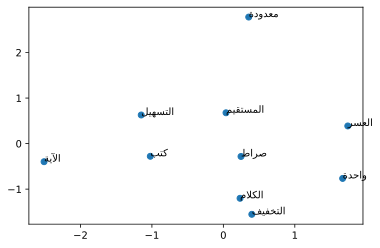

In [521]:
result= compute_pca(X, 4)
plt.scatter(result[:, 1], result[:, 3])
for i, word in enumerate(words):
    reshaped_text = arabic_reshaper.reshape(word)
    artext = get_display(reshaped_text)
    plt.annotate(artext, xy=(result[i, 1], result[i, 3]))
plt.show()

# Evaluation of word vectors

In [522]:
# get vectors
v = word_embeddings['صراط']
w = word_embeddings['مستقيم']

from numpy import linalg

# Calculate Euclidean distance d
d = linalg.norm(v-w)
print("The Euclidean distance between v and w is: ", d)

# Calculate Cosine similarity c
c = np.dot(v,w) / (linalg.norm(v)*linalg.norm(w))
print("The Cosine similarity of v and w is: ", c)

The Euclidean distance between v and w is:  5.04158705419895
The Cosine similarity of v and w is:  0.8533793845892417


In [523]:
words = ['كُتِب', 'سياق','المستقيم','صراط', 'الْعُسرَ','الكلام','واحدة',
         'التسهيل','التخفيف','معدودة']
for i in range(len(words)-1):
    v = word_embeddings[words[i]]
    w = word_embeddings[words[i+1]]
    
    # Calculate Euclidean distance d
    d = linalg.norm(v-w)
    print(f"The Euclidean distance between {words[i]} and {words[i+1]} is: {d}")

    # Calculate Cosine similarity c
    c = np.dot(v,w) / (linalg.norm(v)*linalg.norm(w))
    print(f"The Cosine similarity of {words[i]} and {words[i+1]} is: {c}")
    print()

The Euclidean distance between كُتِب and سياق is: 5.2354727802226435
The Cosine similarity of كُتِب and سياق is: 0.8566488232768509

The Euclidean distance between سياق and المستقيم is: 4.84578619512859
The Cosine similarity of سياق and المستقيم is: 0.8640371090312765

The Euclidean distance between المستقيم and صراط is: 5.259913079994096
The Cosine similarity of المستقيم and صراط is: 0.8389827771054575

The Euclidean distance between صراط and الْعُسرَ is: 5.139500006996931
The Cosine similarity of صراط and الْعُسرَ is: 0.8508816887328288

The Euclidean distance between الْعُسرَ and الكلام is: 5.162874076885181
The Cosine similarity of الْعُسرَ and الكلام is: 0.8538438784163875

The Euclidean distance between الكلام and واحدة is: 4.788627009922312
The Cosine similarity of الكلام and واحدة is: 0.8698387110423449

The Euclidean distance between واحدة and التسهيل is: 5.104109555543222
The Cosine similarity of واحدة and التسهيل is: 0.8465976234363851

The Euclidean distance between التسهيل

In [524]:
# Create a dataframe out of the dictionary embedding.
import pandas as pd
keys = word_embeddings.keys()
data = []
for key in keys:
    data.append(word_embeddings[key])
    
embedding = pd.DataFrame(data=data, index=keys)

In [525]:
embedding.head(10)

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
.,0.480443,0.283808,0.657692,0.477007,0.306739,0.409492,0.355969,0.742651,0.393640,0.486879,...,0.439281,0.334351,0.038674,0.801509,0.548541,0.500443,0.660272,0.668095,0.356151,0.314951
...,0.384666,0.587226,0.409756,0.214188,0.299467,0.411444,0.770008,0.517755,0.531343,0.377741,...,0.481674,0.100532,0.406571,0.786135,0.394173,0.413290,0.292303,0.472427,0.548860,0.584819
ءامنوا,0.527267,0.504387,0.651234,0.244994,0.460760,0.726602,0.839746,0.714968,0.663614,0.485505,...,0.564574,0.567914,0.405870,0.384340,0.292229,0.805380,0.760430,0.199092,0.279791,0.517728
ءَابَاءَكمْ,0.470292,0.606138,0.761361,0.494166,0.182618,0.672992,0.632359,0.678456,0.647354,0.415016,...,0.409524,0.445931,0.472611,0.358083,0.395694,0.617063,0.378032,0.498188,0.802756,0.653550
ءَاتَاهُ,0.700473,0.255888,0.585801,0.765196,0.557402,0.348817,0.490594,0.747412,0.472114,0.285588,...,0.542632,0.620798,0.167979,0.738588,0.502452,0.432386,0.583184,0.645271,0.124530,0.818481
ءَاتَوُا,0.834434,0.685366,0.458867,0.115128,0.817496,0.604271,0.537173,0.727892,0.610917,0.801041,...,0.444043,0.743104,0.727451,0.183581,0.700556,0.542912,0.289967,0.426731,0.406214,0.346710
ءَاتَيْتُم,0.295303,0.836113,0.654716,0.926416,0.773794,0.359804,0.621421,0.412844,0.219472,0.408620,...,0.173900,0.345241,0.700324,0.369727,0.342207,0.340599,0.393950,0.652161,0.670158,0.595553
ءَاتَيْتُمُوهُنّ,0.171722,0.386226,0.613521,0.277214,0.423493,0.220913,0.517200,0.287487,0.530844,0.507636,...,0.431040,0.202760,0.852324,0.322532,0.112981,0.448155,0.455751,0.332340,0.284143,0.639390
ءَاتَيْنَا,0.461658,0.489805,0.707085,0.753386,0.471226,0.482279,0.375870,0.429469,0.526472,0.795113,...,0.553443,0.625801,0.443345,0.699385,0.659746,0.398477,0.477712,0.156211,0.618773,0.588729
ءَاتَيْنَهُم,0.563923,0.348200,0.480134,0.664716,0.272840,0.549646,0.453913,0.337246,0.500897,0.145364,...,0.572588,0.362349,0.400021,0.714564,0.267607,0.638477,0.741195,0.560016,0.613543,0.893463


In [526]:
def cosine_similarity(v, w):
    c = np.dot(v,w) / (linalg.norm(v)*linalg.norm(w))
    return c

In [527]:
def euclidean_distance(v, w):
    d = linalg.norm(v-w)
    return d

In [528]:
# Define a function to find the closest word to a vector:
def find_closest_word(word, k, embeddings=word_embeddings):
    
    most_closest_words = []
    word_emb = embeddings[word]
    similar_word = ''
    
    for w in embeddings.keys():
        if word != w:
            # get the word embedding
            w_emb = embeddings[w]
            # calculating cosine similarity
            cur_similarity = cosine_similarity(word_emb, w_emb)
            # store the similar_word as a tuple, which contains the word and the similarity
            similar_word = (w, cur_similarity)
            # append each tuple to list
            most_closest_words.append(similar_word)
    # sort based on more similarity
    most_closest_words.sort(key=lambda y: -y[1])
    return most_closest_words[:k]
    

In [209]:
find_closest_word('موهبة',20)

[('دهر', 0.8908905226669174),
 ('كالأكل', 0.8896157986332345),
 ('كالمبلغين', 0.8891861731048959),
 ('بهداية', 0.8888282120246442),
 ('الْمُحْسِنِينَ', 0.886229007772556),
 ('الفعال', 0.8858562535698237),
 ('كالخطإ', 0.885528152786348),
 ('بَشِرُوهُنّ', 0.8854308925740851),
 ('خادمك', 0.88491925786648),
 ('الدفاع', 0.884650172893682),
 ('القيراط', 0.8836602502332526),
 ('عزما', 0.8834414912262861),
 ('يكمل', 0.883433081927933),
 ('النساء', 0.8824060982563813),
 ('صاح', 0.8821638526862252),
 ('فقدت', 0.8820838616535681),
 ('كرائم', 0.8820329336826035),
 ('متميزة', 0.8819748609356548),
 ('حكمته', 0.8819534519323423),
 ('المستقيم', 0.8818677211150345)]

In [529]:
find_closest_word('موهبة',20)

[('بطريقين', 0.8894878997086532),
 ('تكلمنا', 0.8869620961074097),
 ('المكتسب', 0.8868991096703552),
 ('الشد', 0.8867261828147778),
 ('ذكرناه', 0.8864436720122795),
 ('محققات', 0.8856597206723077),
 ('أَمْرُهُ', 0.8845838784532364),
 ('كلي', 0.8844249684060734),
 ('فصدر', 0.8843802795453902),
 ('عودها', 0.8837576543311014),
 ('يكفيها', 0.8837370693147719),
 ('أخبرنا', 0.8836531366911106),
 ('اسألوا', 0.8831884958908255),
 ('التكامل', 0.8828711425345368),
 ('شاكرين', 0.8820809363115895),
 ('ألطف', 0.8819091920555622),
 ('الحلال', 0.8818487569960408),
 ('نقيرا', 0.8815503489114329),
 ('النافذة', 0.8806771084048777),
 ('وحيه', 0.8805947198647512)]

In [530]:
find_closest_word('صراط',20)

[('القرائن', 0.8903531904235436),
 ('تفيد', 0.8896095443613282),
 ('شفَعَةٌ', 0.8888014307094969),
 ('بِهَا', 0.8872853301557889),
 ('مسيره', 0.8867988599647847),
 ('ضمنت', 0.886646701816584),
 ('بقتالهم', 0.8855086047763728),
 ('ألطف', 0.8854303395540559),
 ('ذكرناه', 0.8846420159431188),
 ('عوارض', 0.8846142717342684),
 ('فآذنوا', 0.8840054335784683),
 ('آحادا', 0.883915461973076),
 ('تاه', 0.88372456508546),
 ('توهمه', 0.8833606765136056),
 ('للقتال', 0.8833254482973396),
 ('بَقِيّةٌ', 0.8832417891236043),
 ('دعاء', 0.8831660760312907),
 ('المتهوسين', 0.8829748340938427),
 ('بتشبيه', 0.8828242579747085),
 ('مصداقه', 0.8827447909370727)]

In [496]:
find_closest_word('صراط',20)

[('وفاقا', 0.8935907309971964),
 ('امرأته', 0.8930039581360909),
 ('الاجتماع', 0.891727741166803),
 ('انصرف', 0.8915279277215168),
 ('حشر', 0.8910685336626643),
 ('الفصال', 0.8909125598078397),
 ('اللفظية', 0.8907983859946157),
 ('رواحة', 0.8907845642966642),
 ('هين', 0.8907200222518045),
 ('خطاءين', 0.8904953874825934),
 ('التعمية', 0.8900956136047363),
 ('صادف', 0.8899669764102136),
 ('فقذفها', 0.889929651456953),
 ('الأنعام', 0.8897524442565389),
 ('فمثله', 0.8897111073063942),
 ('نقلنا', 0.8893878227966519),
 ('الاطلاع', 0.889319924794362),
 ('طغيانه', 0.8890568578635846),
 ('للتشريع', 0.889034525708756),
 ('فاشتق', 0.8887403153894429)]